# Import Modules
# Detector & Predictor

In [2]:
import dlib
from utils.aux_functions import *
import argparse
from matplotlib import pyplot as plt
import cv2

detector = dlib.get_frontal_face_detector() # 얼굴 좌표찾기 함수 (여러명도 가능)

path_to_dlib_model = "./dlib_models/shape_predictor_68_face_landmarks.dat"
if not os.path.exists(path_to_dlib_model):
    download_dlib_model()
    
predictor = dlib.shape_predictor(path_to_dlib_model) # 얼굴 랜드마크 68개 점 찾기

# Define Function(mask_the_face_correctly)

In [31]:
def mask_the_face_correctly(face_image, mask_type):
    
    ##### 얼굴 좌표 찾기 #####
    face_locations = detector(face_image, 1) # return rectangles 객체 (여러명 얼굴인식)
    face_location = face_locations[0] # 1명만 얼굴인식
    
    
    ##### 얼굴 랜드마크별 68개 좌표 찾기 #####
    shape = predictor(face_image, face_location) # 68개 점 좌표
    shape = face_utils.shape_to_np(shape)
    face_landmarks = shape_to_landmarks(shape) # 얼굴 랜드마크별 68개의 점 좌표(groupby)
    face_location = rect_to_bb(face_location) # rectangles 객체를 튜플로 변환

    
    ##### 마스크를 씌울 6개의 얼굴좌표, 얼굴각도 #####
    six_points_on_face, angle = get_six_points(face_landmarks, face_image)  
    
    
    ##### 어떤 마스크를 쓸것인지 선정 (정면사진임으로 얼굴각도 판단X) #####
    cfg = read_cfg(config_filename="./masks/masks_metadata.cfg", mask_type=mask_type, verbose=False)
    mask_image = cv2.imread(cfg.template, cv2.IMREAD_UNCHANGED) # cv2.IMREAD_UNCHANGED : 투명도인 Alpha 채널을 포함하여 원본 그대로 읽는다
    mask_dots = np.float32([cfg.mask_a, cfg.mask_b, cfg.mask_c, cfg.mask_f, cfg.mask_e, cfg.mask_d]) # 마스크 육각형 꼭지점 좌표
    
    
    ##### 마스크 위치를 얼굴 위치(6개 좌표)와 동기화 #####
    M, mask = cv2.findHomography(mask_dots, six_points_on_face)
    w = face_image.shape[1] # 이미지 열 크기(가로)
    h = face_image.shape[0] # 이미지 행 크기(세로)
    dst_mask = cv2.warpPerspective(mask_image, M, (w, h))
    dst_mask_points = cv2.perspectiveTransform(mask_dots.reshape(-1, 1, 2), M)
    mask = dst_mask[:, :, 3]
    
    
    ##### 얼굴에 마스크 합성 #####    
    # Adjust Brightness
    mask_brightness = get_avg_brightness(mask_image)
    img_brightness = get_avg_brightness(face_image)
    delta_b = 1 + (img_brightness - mask_brightness) / 255
    dst_mask = change_brightness(dst_mask, delta_b)

    # Adjust Saturation
    mask_saturation = get_avg_saturation(mask_image)
    img_saturation = get_avg_saturation(face_image)
    delta_s = 1 - (img_saturation - mask_saturation) / 255
    dst_mask = change_saturation(dst_mask, delta_s)

    # Apply mask
    mask_inv = cv2.bitwise_not(mask)
    img_bg = cv2.bitwise_and(face_image, face_image, mask=mask_inv) # 얼굴이미지 마스크부분 배경제거(비트연산)
    img_fg = cv2.bitwise_and(dst_mask, dst_mask, mask=mask) # 마스크 이외 배경제거(비트연산)
    with_mask = cv2.add(img_bg, img_fg[:, :, 0:3])
    
    
    return with_mask

# Mask The Face Correctly in Directory

In [32]:
import glob

img_path_list = glob.glob('../Gray Scaled/new_without_mask/*.png')
print(len(img_path_list)) # 10000개

mask_type_list= ['KF94_0', 'surgical', 'cloth', 'KF94_2', 'KN95']

for i, img_path in enumerate(img_path_list): 
    original_image = cv2.imread(img_path)
    face_image = original_image.copy()

    try:
        maskid = i // 2000 # i : 0~9999, maskid : 0,1,2,3,4
        if maskid == 0:
            with_mask = mask_the_face_correctly(face_image, mask_type_list[maskid])
            new_img_path = './Gray Scaled/with_mask/with_mask_' + str(i) + '.jpg' 
            cv2.imwrite(new_img_path, with_mask)
        elif maskid == 1:
            with_mask = mask_the_face_correctly(face_image, mask_type_list[maskid])
            new_img_path = './Gray Scaled/with_mask/with_mask_' + str(i) + '.jpg' 
            cv2.imwrite(new_img_path, with_mask)
        elif maskid == 2:
            with_mask = mask_the_face_correctly(face_image, mask_type_list[maskid])
            new_img_path = './Gray Scaled/with_mask/with_mask_' + str(i) + '.jpg' 
            cv2.imwrite(new_img_path, with_mask)
        elif maskid == 3:
            with_mask = mask_the_face_correctly(face_image, mask_type_list[maskid])
            new_img_path = './Gray Scaled/with_mask/with_mask_' + str(i) + '.jpg' 
            cv2.imwrite(new_img_path, with_mask)
        elif maskid == 4:
            with_mask = mask_the_face_correctly(face_image, mask_type_list[maskid])
            new_img_path = './Gray Scaled/with_mask/with_mask_' + str(i) + '.jpg' 
            cv2.imwrite(new_img_path, with_mask)
        

        if i % 500 == 0:
            print('complete:', img_path)
            
    # 모든 예외의 에러 메시지를 출력할 때는 Exception을 사용
    except Exception as e:
        print('Error:', e, img_path) # ../Gray Scaled Classification/with_mask/with_mask_2663.jpg 오류(제거)

10000
complete: ../Gray Scaled/new_without_mask/seed0000.png
complete: ../Gray Scaled/new_without_mask/seed0500.png
complete: ../Gray Scaled/new_without_mask/seed1000.png
complete: ../Gray Scaled/new_without_mask/seed1500.png
complete: ../Gray Scaled/new_without_mask/seed2000.png
complete: ../Gray Scaled/new_without_mask/seed2500.png
Error:  ../Gray Scaled/new_without_mask/seed2663.png
complete: ../Gray Scaled/new_without_mask/seed3000.png
complete: ../Gray Scaled/new_without_mask/seed3500.png
complete: ../Gray Scaled/new_without_mask/seed4000.png
complete: ../Gray Scaled/new_without_mask/seed4500.png
complete: ../Gray Scaled/new_without_mask/seed5000.png
complete: ../Gray Scaled/new_without_mask/seed5500.png
complete: ../Gray Scaled/new_without_mask/seed6000.png
complete: ../Gray Scaled/new_without_mask/seed6500.png
complete: ../Gray Scaled/new_without_mask/seed7000.png
complete: ../Gray Scaled/new_without_mask/seed7500.png
complete: ../Gray Scaled/new_without_mask/seed8000.png
comple

# Define Function(mask_the_face_incorrectly)

In [9]:
def mask_the_face_incorrectly(face_image, mask_type):
    
    ##### 얼굴 좌표 찾기 #####
    face_locations = detector(face_image, 1) # return rectangles 객체 (여러명 얼굴인식)
    face_location = face_locations[0] # 1명만 얼굴인식
    
    
    ##### 얼굴 랜드마크별 68개 좌표 찾기 #####
    shape = predictor(face_image, face_location) # 68개 점 좌표
    shape = face_utils.shape_to_np(shape)
    face_landmarks = shape_to_landmarks(shape) # 얼굴 랜드마크별 68개의 점 좌표(groupby)
    face_location = rect_to_bb(face_location) # rectangles 객체를 튜플로 변환

    
    ##### 마스크를 씌울 6개의 얼굴좌표(코스크), 얼굴각도 #####
    six_points_on_face, angle = get_six_points(face_landmarks, face_image)  
    
    six_points_on_face_around = np.around(six_points_on_face)
    
    face_a = six_points_on_face_around[0]
    face_b = six_points_on_face_around[1]
    face_c = six_points_on_face_around[2]
    face_f = six_points_on_face_around[3]
    face_e = six_points_on_face_around[4]
    face_d = six_points_on_face_around[5]

    a = (face_a[0]+face_d[0])/2
    b = (face_a[1]+face_d[1])/2.1
    face_a_2 = np.array([a,b])

    a = (face_b[0]+face_e[0])/2
    b = (face_b[1]+face_e[1])/2.1
    face_b_2 = np.array([a,b])

    a = (face_c[0]+face_f[0])/2
    b = (face_c[1]+face_f[1])/2.1
    face_c_2 = np.array([a,b])
    
    six_points_on_face = np.float32([face_a_2, face_b_2, face_c_2, face_f, face_e, face_d])
    
    
    ##### 어떤 마스크를 쓸것인지 선정 (정면사진임으로 얼굴각도 판단X) #####
    cfg = read_cfg(config_filename="./masks/masks_metadata.cfg", mask_type=mask_type, verbose=False)
    mask_image = cv2.imread(cfg.template, cv2.IMREAD_UNCHANGED) # cv2.IMREAD_UNCHANGED : 투명도인 Alpha 채널을 포함하여 원본 그대로 읽는다
    mask_dots = np.float32([cfg.mask_a, cfg.mask_b, cfg.mask_c, cfg.mask_f, cfg.mask_e, cfg.mask_d]) # 마스크 육각형 꼭지점 좌표
    
    
    ##### 마스크 위치를 얼굴 위치(6개 좌표)와 동기화 #####
    M, mask = cv2.findHomography(mask_dots, six_points_on_face)
    w = face_image.shape[1] # 이미지 열 크기(가로)
    h = face_image.shape[0] # 이미지 행 크기(세로)
    dst_mask = cv2.warpPerspective(mask_image, M, (w, h))
    dst_mask_points = cv2.perspectiveTransform(mask_dots.reshape(-1, 1, 2), M)
    mask = dst_mask[:, :, 3]
    
    
    ##### 얼굴에 마스크 합성 #####    
    # Adjust Brightness
    mask_brightness = get_avg_brightness(mask_image)
    img_brightness = get_avg_brightness(face_image)
    delta_b = 1 + (img_brightness - mask_brightness) / 255
    dst_mask = change_brightness(dst_mask, delta_b)

    # Adjust Saturation
    mask_saturation = get_avg_saturation(mask_image)
    img_saturation = get_avg_saturation(face_image)
    delta_s = 1 - (img_saturation - mask_saturation) / 255
    dst_mask = change_saturation(dst_mask, delta_s)

    # Apply mask
    mask_inv = cv2.bitwise_not(mask)
    img_bg = cv2.bitwise_and(face_image, face_image, mask=mask_inv) # 얼굴이미지 마스크부분 배경제거(비트연산)
    img_fg = cv2.bitwise_and(dst_mask, dst_mask, mask=mask) # 마스크 이외 배경제거(비트연산)
    without_mask = cv2.add(img_bg, img_fg[:, :, 0:3])
    
    
    return without_mask

# Mask The Face Incorrectly In Directory

In [30]:
import glob

img_path_list = glob.glob('../Gray Scaled/new_without_mask/*.png')
print(len(img_path_list)) # 10000개

mask_type_list= ['KF94_0', 'surgical', 'cloth', 'KF94_2', 'KN95']

for i, img_path in enumerate(img_path_list): 
    original_image = cv2.imread(img_path)
    face_image = original_image.copy()

    new_img_path = './Gray Scaled/without_mask/without_mask_' + str(i) + '.jpg'
    
    # 0~3999 맨얼굴
    if i < 4000:
        cv2.imwrite(new_img_path, face_image)
        continue
        
    # 마스크별로 코스크 합성
    else:
        try:
            new_img_path = './Gray Scaled/without_mask/without_mask_' + str(i) + '.jpg'
            if 4000 <= i <= 5199:
                without_mask = mask_the_face_incorrectly(face_image, mask_type_list[0])
                cv2.imwrite(new_img_path, without_mask)
            elif 5200 <= i <= 6399:
                without_mask = mask_the_face_incorrectly(face_image, mask_type_list[1])
                cv2.imwrite(new_img_path, without_mask)
            elif 6400 <= i <= 7599:
                without_mask = mask_the_face_incorrectly(face_image, mask_type_list[2])
                cv2.imwrite(new_img_path, without_mask)
            elif 7600 <= i <= 8799:
                without_mask = mask_the_face_incorrectly(face_image, mask_type_list[3])
                cv2.imwrite(new_img_path, without_mask)
            elif 8800 <= i <= 9999:
                without_mask = mask_the_face_incorrectly(face_image, mask_type_list[4])
                cv2.imwrite(new_img_path, without_mask)
            
        # 모든 예외의 에러 메시지를 출력할 때는 Exception을 사용
        except Exception as e:
            print('Error:', e, img_path)
            
        if i % 500 == 0:
            print('complete:', img_path)

10000
complete: ../Gray Scaled/new_without_mask/seed4000.png
complete: ../Gray Scaled/new_without_mask/seed4500.png
complete: ../Gray Scaled/new_without_mask/seed5000.png
complete: ../Gray Scaled/new_without_mask/seed5500.png
complete: ../Gray Scaled/new_without_mask/seed6000.png
complete: ../Gray Scaled/new_without_mask/seed6500.png
complete: ../Gray Scaled/new_without_mask/seed7000.png
complete: ../Gray Scaled/new_without_mask/seed7500.png
complete: ../Gray Scaled/new_without_mask/seed8000.png
complete: ../Gray Scaled/new_without_mask/seed8500.png
complete: ../Gray Scaled/new_without_mask/seed9000.png
complete: ../Gray Scaled/new_without_mask/seed9500.png


# Load Mask Metadata

In [14]:
def getMaskDots(mask_type):
    ##### 선정된 마스크 6개 좌표 불러오기 #####
    cfg = read_cfg(config_filename="./masks/masks_metadata.cfg", mask_type=mask_type, verbose=False)
    mask_image = cv2.imread(cfg.template, cv2.IMREAD_UNCHANGED) # cv2.IMREAD_UNCHANGED : 투명도인 Alpha 채널을 포함하여 원본 그대로 읽는다
    mask_dots = np.float32([cfg.mask_a, cfg.mask_b, cfg.mask_c, cfg.mask_f, cfg.mask_e, cfg.mask_d]) # 마스크 육각형 꼭지점 좌표
    
    return mask_dots

[[500.  85.]
 [290.   0.]
 [ 35.  85.]
 [ 80. 360.]
 [280. 440.]
 [500. 350.]]


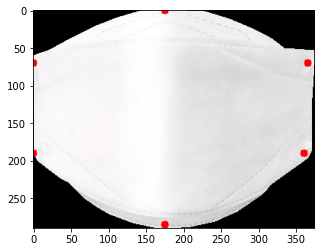

In [28]:
img_mask = cv2.cvtColor(cv2.imread('./masks/templates/KF94_0.png'), cv2.COLOR_BGR2RGB)

mask_dots_list = getMaskDots('KF94_0')
print(mask_dots_list)

color_red = (255,0,0)
mask_dots = cv2.circle(img_mask, (365,70), 5, color_red, -1) # a
mask_dots = cv2.circle(img_mask, (175,0), 5, color_red, -1) # b
mask_dots = cv2.circle(img_mask, (0,70), 5, color_red, -1) # c
mask_dots = cv2.circle(img_mask, (0,190), 5, color_red, -1) # f
mask_dots = cv2.circle(img_mask, (175,285), 5, color_red, -1) # e
mask_dots = cv2.circle(img_mask, (360,190), 5, color_red, -1) # d
plt.imshow(mask_dots)